# Abstract

This work aims to predict the qualification for the playoffs in the upcoming NHL season (2023-2024) based on the game features using neural network.
This work is continuation of the Midterm work which used the kNN and Decision tree algorithms for prediction.


# Introduction

The National Hockey League is a professional ice hockey league in North America consisting of 32 (as of 2023) teams: 25 in the United States and 7 in Canada. 
Eight teams from each of the two conferences qualify for the playoffs based on their total regular season points.
Thus, it is not possible to win the Stanley Cup without being qualified for playoffs. 

Making precise predictions might help coaches improve team game strategies and adjust plans before the next game.

The dataset was taken from the MoneyPuck [source](https://moneypuck.com/moneypuck/playerData/careers/gameByGame/all_teams.csv). 
The data is free to use. No guarantees are made to the quality of the data. NHL data is known to have issues and biases. 
Data is summarized on the season level and a game-by-game level going from 2008 up to 2023. 
The data for 2022 and 2023 will be filtered out because the prediction is going to be made for the 2022-2024 seasons 
and data for seasons up to 2022 is taken from the [file](https://moneypuck.com/moneypuck/playerData/seasonSummary/2023/regular/teams.csv)



In [591]:
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import models
from keras import layers

# Methodology


## 4.5.1. Defining the problem and assembling a dataset

I am trying to predict whether a team is qualified for playoff or not based on historical data. 
The historical data contains the column `playoffGame` a flag depicting whether a game was played during playoffs. 
Thus, if a team plays at least one game during the season’s playoff it means that the team has been qualified for the playoff.
This is binary classification problem

In [592]:
def read_nhl_data():
    _nhl_data = pd.read_csv('moneypack/all_teams.csv')
    _nhl_data = _nhl_data.dropna()

    columns_to_drop = [
        'name', 'gameId', 'playerTeam',
        'opposingTeam', 'home_or_away',
        'gameDate', 'position',
        'situation', 'iceTime',
        #'playoffGame'
    ]

    _nhl_data = _nhl_data.sort_values(by=['team', 'season'])
    _nhl_data = _nhl_data.drop(columns=columns_to_drop)
    _nhl_data = _nhl_data.groupby(['team', 'season'], as_index=False).mean()
    _nhl_data['playoff_qualified'] = _nhl_data['playoffGame'].apply(lambda val: 1 if val > 0 else 0)
    _nhl_data = _nhl_data.drop(columns=['playoffGame'])

    return _nhl_data


def read_nhl_data_2023():
    _nhl_data_2023 = pd.read_csv('moneypack/teams_2023.csv')
    columns_to_drop_from_2023 = ['name', 'position', 'situation', 'iceTime', 'team.1', 'games_played']

    _nhl_data_2023 = _nhl_data_2023.dropna()
    _nhl_data_2023 = _nhl_data_2023.drop(columns=columns_to_drop_from_2023)
    _nhl_data_2023 = _nhl_data_2023.sort_values(by=['team', 'season'])
    _nhl_data_2023 = _nhl_data_2023.groupby(['team', 'season']).mean()
    return _nhl_data_2023


def get_team_names(_team_data):
    duplicates = pd.DataFrame(_team_data['team']).drop_duplicates(subset=None, keep='first', inplace=False,
                                                                  ignore_index=False)
    duplicates = duplicates.sort_values(by=['team'])
    return duplicates['team'].values

In [ ]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2023)]
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2022)]

seasons_data_all = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_all = by_team_season_all['playoff_qualified'].values

## 4.5.2. Choosing a measure of success
To select the main metrics for success for the binary classification problem we need to understand if the classes are approximately equal.
Try to visualize the classes and calculate the imbalance ratio as follows

In [ ]:
class_counts = pd.Series(seasons_target_all).value_counts()
class_proportions = pd.Series(seasons_target_all).value_counts(normalize=True)
imbalance_ratio = class_counts[0] / class_counts[1]  # Assuming binary classification
print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)
print("Imbalance Ratio:", imbalance_ratio)
plt.hist(seasons_target_all)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Target Classes')
plt.show()

Classes are almost balanced and the Accuracy can be used as the main metrics for success. 
TBD it defines the loss function. 

## 4.5.3. Deciding on an evaluation protocol
Doing iterated K-fold validation— For performing highly accurate model evaluation when little data is available

## 4.5.4. Preparing your data
 data should be formatted as tensors.
 The values taken by these tensors should usually be scaled to small values: for example, in the [-1, 1] range or [0, 1] range.
 the data should be normalized.

Get data for 2022 as test set?

In [ ]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] == 2022)]

seasons_teams_2022 = get_team_names(by_team_season_all)
seasons_data_2022 = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_2022 = by_team_season_all['playoff_qualified'].values

Get data for 2023 as validation set?

In [ ]:
seasons_data_2023 = read_nhl_data_2023()
seasons_teams_2023 = get_team_names(pd.read_csv('moneypack/teams_2023.csv'))
seasons_target_2023 = [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
                       0]  #<40

Transform features by scaling each feature to a given range.
This MinMaxScaler estimator scales and translates each feature individually such that it is in the given range on the training set, between zero and one.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
seasons_data_all = scaler.fit_transform(seasons_data_all)
seasons_data_2022 = scaler.fit_transform(seasons_data_2022)
seasons_data_2023 = scaler.fit_transform(seasons_data_2023)
print(seasons_data_2022)

## 4.5.5. Developing a model that does better than a baseline
Assuming that things go well, you need to make three key choices to build your first working model:

Last-layer activation - sigmoid in the last layer
Loss function - binary_crossentropy
Optimization configuration - What optimizer will you use? What will its learning rate be? In most cases, it’s safe to go with rmsprop and its default learning rate

In [ ]:
from keras.src.layers import Dense
from keras import Sequential

data = seasons_data_all
target = seasons_target_all

model = Sequential([
    Dense(64, activation='relu', input_shape=(seasons_data_all.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


you’ll now train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples.
 At the same time, you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the validation_data argument.

train on the training data and evaluate your model on the validation data. 
Simple hold-out validation

In [ ]:
def plot_history(title, xlabel, ylabel, plot1_label, plot1_vals, plot2_label, plot2_vals):
    plt.clf()
    epochs = range(1, len(plot1_vals) + 1)
    plt.plot(epochs, plot1_vals, 'bo', label=plot1_label)
    plt.plot(epochs, plot2_vals, 'b', label=plot2_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
num_validation_samples = len(data)
# np.random.shuffle(data)

print(num_validation_samples)
limit = 320

x_val = data[:limit]
y_val = target[:limit]
partial_x_train = data[limit:]
partial_y_train = target[limit:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    # batch_size=256,
                    validation_data=(x_val, y_val))

history_dict = history.history
plot_history('Training and validation loss', 'Epochs', 'Loss',
             'Training loss',  history_dict['loss'], 'Validation loss',  history_dict['val_loss'])
plot_history('Training and validation accuracy', 'Epochs', 'Accuracy',
             'Training acc',  history_dict['accuracy'], 'Validation acc', history_dict['val_accuracy'])


As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient-descent optimization—the quantity you’re trying to minimize should be less with every iteration

Test it on the test data for 2022

In [ ]:
simple_prediction_2022 = model.evaluate(seasons_data_2022, seasons_target_2022)
print(f'Simple model prediction accuracy is {simple_prediction_2022[1]}, loss is {simple_prediction_2022[0]}')

You train on the training data and evaluate your model on the validation data. 
Once your model is ready for prime time, you test it one final time on the test data. 
(2022 test data)
2023 - new data for prediction
so i need to split seasons_data_all_features to training and validation data

## 4.5.6. Scaling up: developing a model that overfits
To figure out how big a model you’ll need, you must develop a model that overfits. This is fairly easy:

Add layers.
Make the layers bigger.
Train for more epochs.

In [ ]:
from keras.src import regularizers
from keras.src.layers import Dropout

# Add dropout regularization
advanced_model = Sequential([
    Dense(128, activation='relu', input_shape=(seasons_data_all.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

advanced_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

This one is for situations in which you have relatively little data available and you need to evaluate your model as precisely as possible.

In [587]:
from sklearn.model_selection import StratifiedKFold

k = 5
advanced_epochs = 20
advanced_batch_size = 64
num_validation_samples = len(data)
scores = []

kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for train_idx, val_idx in kfold.split(data, target):
    X_train_fold, X_val_fold = data[train_idx], data[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]
    history = advanced_model.fit(X_train_fold,
                        y_train_fold,
                        epochs=advanced_epochs,
                        # batch_size=advanced_batch_size,
                        validation_data=(X_val_fold, y_val_fold))
    scores.append(history)

Epoch 1/20
11/11 [==============================] - 1s 37ms/step - loss: 2.8185 - accuracy: 0.6176 - val_loss: 2.5525 - val_accuracy: 0.6744
Epoch 2/20
11/11 [==============================] - 0s 10ms/step - loss: 2.4217 - accuracy: 0.6941 - val_loss: 2.2331 - val_accuracy: 0.7093
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 2.1527 - accuracy: 0.7441 - val_loss: 1.9596 - val_accuracy: 0.8256
Epoch 4/20
11/11 [==============================] - 0s 9ms/step - loss: 1.9295 - accuracy: 0.7324 - val_loss: 1.7696 - val_accuracy: 0.7791
Epoch 5/20
11/11 [==============================] - 0s 11ms/step - loss: 1.7337 - accuracy: 0.7588 - val_loss: 1.5752 - val_accuracy: 0.8488
Epoch 6/20
11/11 [==============================] - 0s 10ms/step - loss: 1.5643 - accuracy: 0.7676 - val_loss: 1.4208 - val_accuracy: 0.8256
Epoch 7/20
11/11 [==============================] - 0s 10ms/step - loss: 1.4407 - accuracy: 0.7765 - val_loss: 1.3869 - val_accuracy: 0.7326
Epoch 8/20
11/

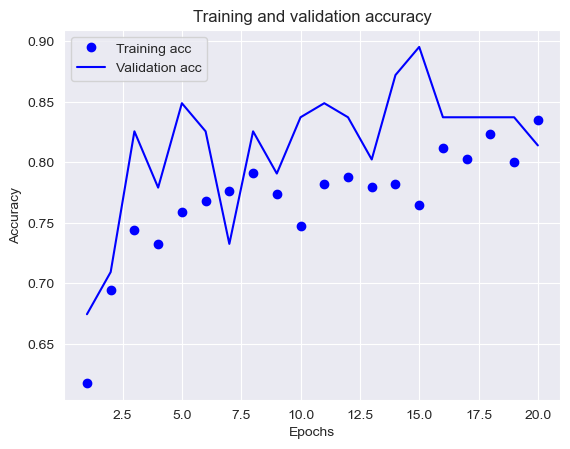

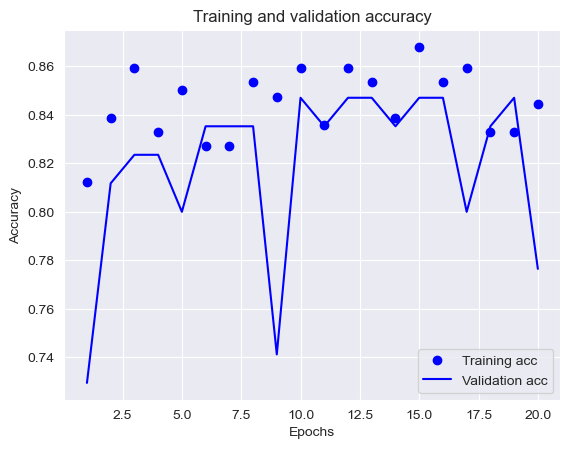

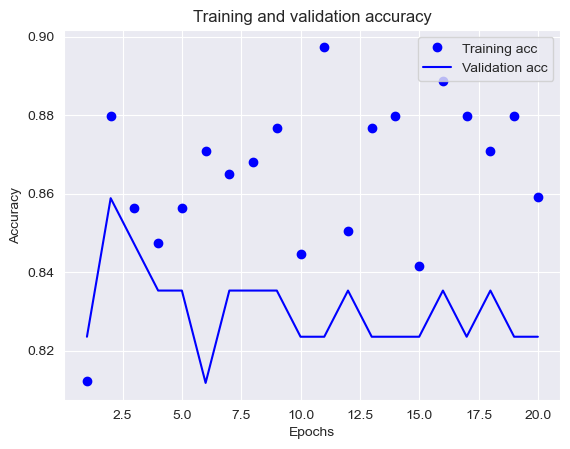

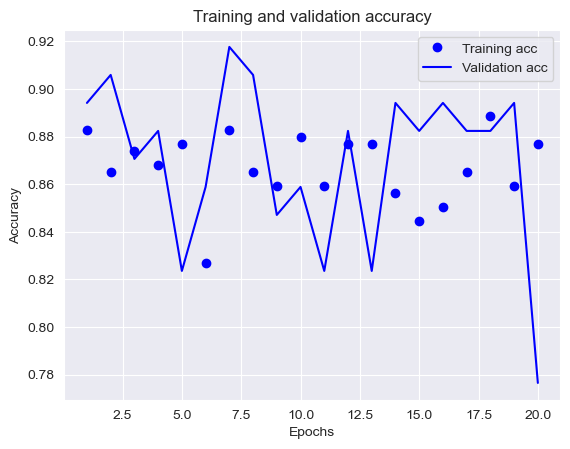

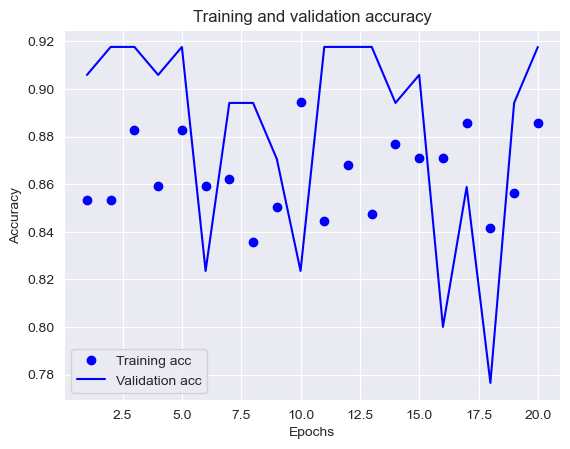

In [588]:
for hist in scores:
    hist_dict = hist.history
    plot_history('Training and validation accuracy', 'Epochs', 'Accuracy',
                 'Training acc',  hist_dict['accuracy'], 'Validation acc', hist_dict['val_accuracy'])

In [589]:
advanced_prediction_2022 = advanced_model.evaluate(seasons_data_2022, seasons_target_2022)
print(f'Advanced model prediction accuracy is {advanced_prediction_2022[1]}, loss is {advanced_prediction_2022[0]}')

1/1 [==============================] - 0s 36ms/step - loss: 0.3545 - accuracy: 0.9062
Advanced model prediction accuracy is 0.90625, loss is 0.35445645451545715


## 4.5.7. Regularizing your model and tuning your hyperparameters
These are some things you should try:

Add dropout.
Try different architectures: add or remove layers.
Add L1 and/or L2 regularization.
Try different hyperparameters (such as the number of units per layer or the learning rate of the optimizer) to find the optimal configuration.
Optionally, iterate on feature engineering: add new features, or remove features that don’t seem to be informative.

# Results


In [590]:
advanced_prediction_2023 = advanced_model.predict(seasons_data_2023).flatten()
print(advanced_prediction_2023)
round_advanced_prediction_2023 = np.where(advanced_prediction_2023 >= 0.8, 1, 0)

final_prediction_2023 = pd.DataFrame(
    {"team": seasons_teams_2022,
     "playoff qualified": round_advanced_prediction_2023,
     "expected": seasons_target_2023}
)
print(f'Prediction for season 2023-2024\n{final_prediction_2023}')

1/1 [==============================] - 0s 93ms/step
[0.01242587 0.82238525 0.98168886 0.425172   0.97872394 0.03675338
 0.83321476 0.00488404 0.99427015 0.9712515  0.9248767  0.9676301
 0.99159807 0.98100007 0.16252981 0.07791335 0.72817445 0.7449689
 0.41453502 0.97894627 0.27671978 0.77509314 0.9866105  0.5112089
 0.00128995 0.2646054  0.8777146  0.9789892  0.9922712  0.98320115
 0.9890345  0.02103145]
Prediction for season 2023-2024
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  1         0
2   BOS                  1         1
3   BUF                  0         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  1         0
11  EDM                  1         1
12  FLA                  1         1
13  LAK                  1         1
14  M

# Evaluation


# Conclusions

# References
